In [5]:
import pandas as pd

# Load CSV files
train_df = pd.read_csv("training_data.csv")
val_df = pd.read_csv("validation_data.csv")
test_df = pd.read_csv("testing_data.csv")

# Check if columns are the same
columns_match = list(train_df.columns) == list(val_df.columns) == list(test_df.columns)
print("All datasets have the same columns and order?", columns_match)

# Print column names and number of columns
print("\nColumn Names:")
print(train_df.columns.tolist())
print("\nNumber of Columns:", len(train_df.columns))

# Print number of rows in each dataset
print("\nNumber of Rows:")
print("Training Data:", len(train_df))
print("Validation Data:", len(val_df))
print("Testing Data:", len(test_df))


All datasets have the same columns and order? True

Column Names:
['date', 'open', 'high', 'low', 'close', 'volume', 'stock', 'daily_variation', 'daily_return', 'sma_7', 'std_7', 'ema_14', 'macd', 'macd_signal', 'cumulative_return', 'gain', 'loss', 'rsi', 'L14', 'H14', 'stochastic_oscillator', 'prev_high', 'prev_low', 'prev_close', 'atr', 'smoothed_plus_dm', 'smoothed_minus_dm', 'dx', 'adx', 'label_3', 'label_7', 'title', 'sentiment']

Number of Columns: 33

Number of Rows:
Training Data: 113239
Validation Data: 24271
Testing Data: 24267


In [6]:
# Check potential target columns
for col in ['label_3', 'label_7']:
    print(f"\n--- {col} ---")
    print("Unique values:", train_df[col].unique())
    print("Value counts:\n", train_df[col].value_counts())



--- label_3 ---
Unique values: ['hold' 'buy' 'sell']
Value counts:
 label_3
hold    85371
buy     15021
sell    12847
Name: count, dtype: int64

--- label_7 ---
Unique values: ['hold' 'sell' 'buy']
Value counts:
 label_7
hold    75547
buy     20855
sell    16837
Name: count, dtype: int64


In [7]:
# stratified split check
def print_label_distribution(df, name):
    counts = df['label_3'].value_counts(normalize=True) * 100
    print(f"\n{name} Label Distribution (%):")
    print(counts.sort_index())  # Sorted for consistent comparison

print_label_distribution(train_df, "Training")
print_label_distribution(val_df, "Validation")
print_label_distribution(test_df, "Testing")



Training Label Distribution (%):
label_3
buy     13.264865
hold    75.390104
sell    11.345031
Name: proportion, dtype: float64

Validation Label Distribution (%):
label_3
buy     13.106176
hold    75.423345
sell    11.470479
Name: proportion, dtype: float64

Testing Label Distribution (%):
label_3
buy     13.644043
hold    75.023695
sell    11.332262
Name: proportion, dtype: float64


# Primitive Baseline

In [8]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def baseline_xgboost(df, target_column='label_3', drop_cols=None, test_size=0.15, random_state=42):
    """
    Trains an XGBoost model on a given DataFrame.

    Args:
        df (pd.DataFrame): The full dataset.
        target_column (str): The name of the target column.
        drop_cols (list): Columns to drop before training.
        test_size (float): Fraction of data to use for validation.
        random_state (int): Seed for reproducibility.

    Returns:
        model (xgb.XGBClassifier): Trained XGBoost model.
        le (LabelEncoder): Fitted label encoder.
        X_train, X_val, y_train, y_val: Split features and labels.
    """
    if drop_cols is None:
        drop_cols = ['label_7', 'title', 'date', 'stock']

    # Encode target
    le = LabelEncoder()
    y = le.fit_transform(df[target_column])

    # Features
    X = df.drop(drop_cols + [target_column], axis=1)

    # Train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Model setup
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        eval_metric='mlogloss',
        random_state=random_state
    )

    # Train
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

    return model, le, X_train, X_val, y_train, y_val


In [9]:
# Load the dataset
training_data = pd.read_csv("training_data.csv")

# Train the model
baseline_model, le, X_train, X_val, y_train, y_val = baseline_xgboost(training_data)


[0]	validation_0-mlogloss:0.92561
[1]	validation_0-mlogloss:0.82687
[2]	validation_0-mlogloss:0.76655
[3]	validation_0-mlogloss:0.72860
[4]	validation_0-mlogloss:0.70451
[5]	validation_0-mlogloss:0.68857
[6]	validation_0-mlogloss:0.67785
[7]	validation_0-mlogloss:0.66991
[8]	validation_0-mlogloss:0.66401
[9]	validation_0-mlogloss:0.65881
[10]	validation_0-mlogloss:0.65484
[11]	validation_0-mlogloss:0.65118
[12]	validation_0-mlogloss:0.64743
[13]	validation_0-mlogloss:0.64418
[14]	validation_0-mlogloss:0.64175
[15]	validation_0-mlogloss:0.63905
[16]	validation_0-mlogloss:0.63710
[17]	validation_0-mlogloss:0.63391
[18]	validation_0-mlogloss:0.63107
[19]	validation_0-mlogloss:0.62869
[20]	validation_0-mlogloss:0.62732
[21]	validation_0-mlogloss:0.62473
[22]	validation_0-mlogloss:0.62343
[23]	validation_0-mlogloss:0.62099
[24]	validation_0-mlogloss:0.61826
[25]	validation_0-mlogloss:0.61599
[26]	validation_0-mlogloss:0.61401
[27]	validation_0-mlogloss:0.61219
[28]	validation_0-mlogloss:0.6

In [18]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load test data
test_data = pd.read_csv("testing_data.csv")

# Prepare features and true labels
drop_cols = ['label_7', 'title', 'date', 'stock']
X_test = test_data.drop(drop_cols + ['label_3'], axis=1)
y_test = le.transform(test_data['label_3'])  # use the SAME encoder

# Predict using the trained model
y_pred = baseline_model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_  # ['buy', 'hold', 'sell']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


NameError: name 'baseline_model' is not defined

# Baseline Model Summary
- Primitve model achieves an overall 81% accuracy, but this is largely driven by the dominance of the "hold" class in the dataset
- While precision is high across all classes, recall is very low for the "buy" and "sell" classes -> model struggles to detect them
- The macro average F1-score is only 0.56 -> imbalanced performance across classes
- Most "buy" and "sell" instances are misclassified as "hold", which inflates the accuracy but reduces the model's usefulness for decision making

# Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

def gridsearch_xgboost(df, target_column='label_3', drop_cols=None, param_grid=None, cv=3, scoring='f1_macro'):
    """
    Perform grid search with 3-fold CV on XGBoost for a given DataFrame.

    Args:
        df (pd.DataFrame): The full dataset.
        target_column (str): Name of the label column.
        drop_cols (list): List of non-feature columns to drop.
        param_grid (dict): Hyperparameters to search.
        cv (int): Number of folds for cross-validation.
        scoring (str): Scoring metric.

    Returns:
        best_model: Trained best XGBoost model.
        grid_search: Full GridSearchCV object (for inspection).
    """
    if drop_cols is None:
        drop_cols = ['label_7', 'title', 'date', 'stock']

    if param_grid is None:
        param_grid = {
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.3],
            'n_estimators': [50, 100],
            'subsample': [0.8, 1.0]
        }

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df[target_column])
    X = df.drop(drop_cols + [target_column], axis=1)

    # XGBoost model
    xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)

    # Grid search
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=1,
        n_jobs=-1  # parallelize
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    return best_model, grid_search


In [12]:
training_data = pd.read_csv("training_data.csv")

best_model, grid_search = gridsearch_xgboost(training_data)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score: 0.49666421445121856


Classification Report:
              precision    recall  f1-score   support

         buy       0.85      0.19      0.32      3311
        hold       0.79      0.99      0.88     18206
        sell       0.91      0.17      0.28      2750

    accuracy                           0.79     24267
   macro avg       0.85      0.45      0.49     24267
weighted avg       0.81      0.79      0.73     24267



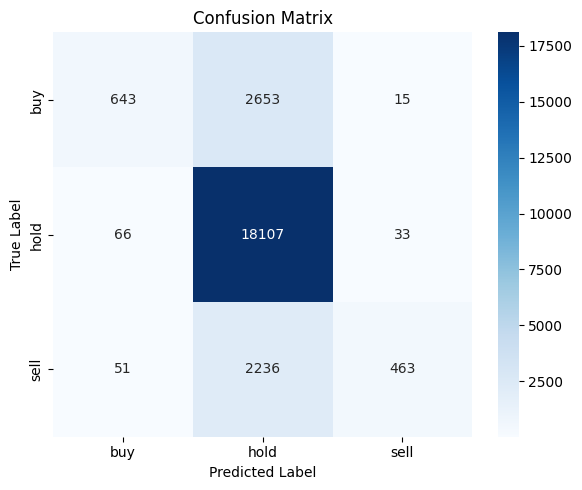

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Best params from grid search
grid_search_best = XGBClassifier(
    learning_rate=0.3,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

# Load the test set
test_data = pd.read_csv("testing_data.csv")

# Prepare features and labels
drop_cols = ['label_7', 'title', 'date', 'stock']
X_test = test_data.drop(drop_cols + ['label_3'], axis=1)
y_test = le.transform(test_data['label_3'])  # same encoder from training

# Predict using the best model from grid search
y_pred = grid_search_best.predict(X_test)

# Print performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix (pretty)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Grid Search Summary
- Results got worst. It seems like we have to address the class imbalance before tackling grid/ optimization

# Class Imbalance
- inverse frequency weighting

In [14]:
import numpy as np
from xgboost import XGBClassifier

# compute class weights (balanced weighting)
class_counts = np.bincount(y_train)  # y_train must be label-encoded (0, 1, 2)
total_samples = len(y_train)
n_classes = len(class_counts)

# Inverse frequency weight: total / (classes × class_count)
class_weights = total_samples / (n_classes * class_counts)
sample_weights = class_weights[y_train]  # Row-wise weights for each training sample

# Train the model
weighted_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)

weighted_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=True
)


[0]	validation_0-mlogloss:1.08921
[1]	validation_0-mlogloss:1.08075
[2]	validation_0-mlogloss:1.07339
[3]	validation_0-mlogloss:1.06648
[4]	validation_0-mlogloss:1.06035
[5]	validation_0-mlogloss:1.05469
[6]	validation_0-mlogloss:1.04959
[7]	validation_0-mlogloss:1.04495
[8]	validation_0-mlogloss:1.04048
[9]	validation_0-mlogloss:1.03661
[10]	validation_0-mlogloss:1.03271
[11]	validation_0-mlogloss:1.02932
[12]	validation_0-mlogloss:1.02656
[13]	validation_0-mlogloss:1.02342
[14]	validation_0-mlogloss:1.02078
[15]	validation_0-mlogloss:1.01786
[16]	validation_0-mlogloss:1.01515
[17]	validation_0-mlogloss:1.01269
[18]	validation_0-mlogloss:1.01029
[19]	validation_0-mlogloss:1.00822
[20]	validation_0-mlogloss:1.00612
[21]	validation_0-mlogloss:1.00396
[22]	validation_0-mlogloss:1.00209
[23]	validation_0-mlogloss:1.00052
[24]	validation_0-mlogloss:0.99872
[25]	validation_0-mlogloss:0.99705
[26]	validation_0-mlogloss:0.99562
[27]	validation_0-mlogloss:0.99416
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

Classification Report:
              precision    recall  f1-score   support

         buy       0.35      0.58      0.44      3311
        hold       0.88      0.69      0.77     18206
        sell       0.32      0.54      0.41      2750

    accuracy                           0.66     24267
   macro avg       0.52      0.60      0.54     24267
weighted avg       0.75      0.66      0.69     24267



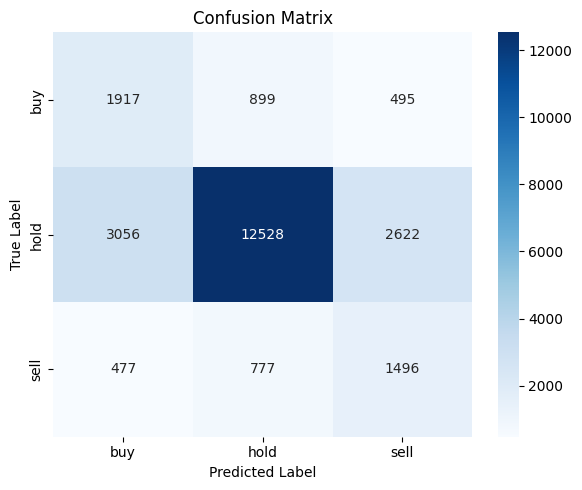

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the test set
test_data = pd.read_csv("testing_data.csv")

# Prepare features and labels
drop_cols = ['label_7', 'title', 'date', 'stock']
X_test = test_data.drop(drop_cols + ['label_3'], axis=1)
y_test = le.transform(test_data['label_3'])  # same encoder from training

# Predict using the best model from grid search
y_pred = weighted_model.predict(X_test)

# Print performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix (pretty)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Weighted Model Summary
- Inverse class weight seems to be working as recall improves for minority class. "Buy" rising from 19%->58% and "sell" from 17%->54%
- Overall accuracy dropped to 66% but this maybe an acceptable tradeoff?
- Macro F1-score improved to 0.54 -> better balance across all classes
Model no longer over-relies on predicting "hold" -> more capable of detecting actionable signals
- Model is more "fair"
## Posible next steps
- Focused Grid Search with weighted model
- softprob to emphasize "buy/hold"
- SMOTE, feature importance (low priority)

# Optuna + Weighted Model
- Intuition: Imbalance is largely solved, tightening tree parameters should be done first before re-balancing again
- Optuna maybe better thatn GridSearchCV. Since it is Bayesian (need further research)

In [11]:
#!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.1 MB/s eta 0:00:00


In [13]:
# runs 200 bayesian trials to find best max_depth, learning_rate, n_estimators, and subsample
# after each trial, measure the performance with the macro-average F1-score on the validation set aka "value"
# and keeps track of the best-scoring parameter combination

import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objective(trial):
    params = {
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'learning_rate':    trial.suggest_float('lr', 0.01, 0.3, log=True),
        'n_estimators':     trial.suggest_int('n_estimators', 100, 600, step=50),
        'subsample':        trial.suggest_float('subsample', 0.6, 1.0),
        'objective':        'multi:softprob',
        'num_class':        3,
        'eval_metric':      'mlogloss',
        'random_state':     42
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')


In [ ]:
# optuna on label_3
l3_study = optuna.create_study(direction='maximize')
l3_study.optimize(objective, n_trials=200)          # 200 trials
print(l3_study.best_params, l3_study.best_value)

Classification Report:
               precision    recall  f1-score   support

         buy       0.92      0.71      0.80      3311
        hold       0.91      0.99      0.95     18206
        sell       0.95      0.69      0.80      2750

    accuracy                           0.92     24267
   macro avg       0.93      0.80      0.85     24267
weighted avg       0.92      0.92      0.91     24267



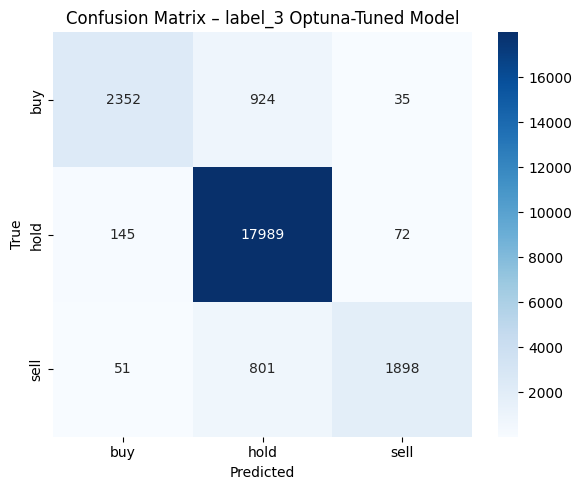

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# ---------- 1. Load data ----------
train_df = pd.read_csv("training_data.csv")
test_df  = pd.read_csv("testing_data.csv")

# ---------- 2. Encode label_3 ----------
le = LabelEncoder()
train_df["label_3_encoded"] = le.fit_transform(train_df["label_3"])
test_df["label_3_encoded"]  = le.transform(test_df["label_3"])

# ---------- 3. Features ----------
drop_cols = ["label_3", "label_3_encoded", "label_7", "date", "stock", "title"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df["label_3_encoded"]

X_test  = test_df[feature_cols]
y_test  = test_df["label_3_encoded"]

# ---------- 4. Inverse class-weights ----------
class_counts = np.bincount(y_train)
weights = len(y_train) / (len(class_counts) * class_counts)
sample_weights = weights[y_train]

# ---------- 5. Train Optuna-best model ----------
l3_optuna_best = {
    "max_depth": 10,
    "learning_rate": 0.14456012100978763,
    "n_estimators": 550,
    "subsample": 0.9218991996569271,
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "random_state": 42,
}
l3_model = XGBClassifier(**l3_optuna_best)
l3_model.fit(X_train, y_train, sample_weight=sample_weights)

# ---------- 6. Evaluate on test set ----------
y_pred = l3_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
cm = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
with open("label3_optuna_report.txt", "w") as f:
    f.write("Classification Report:\n")
    f.write(report)

# ---------- 7. Confusion-matrix plot ----------
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
plt.title("Confusion Matrix – label_3 Optuna-Tuned Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("label3_optuna_confusion_matrix.png")
plt.show()


# Optuna + Weighted Model
- Macro-averaged F1-score of 0.84 and an overall accuracy of 91% on the test set
- Minority classes are well captured, "buy" recall at 68% and "sell" recall at 66%; "hold" recall at 99%
- strong precision between 0.90-0.94

# label_7 Model

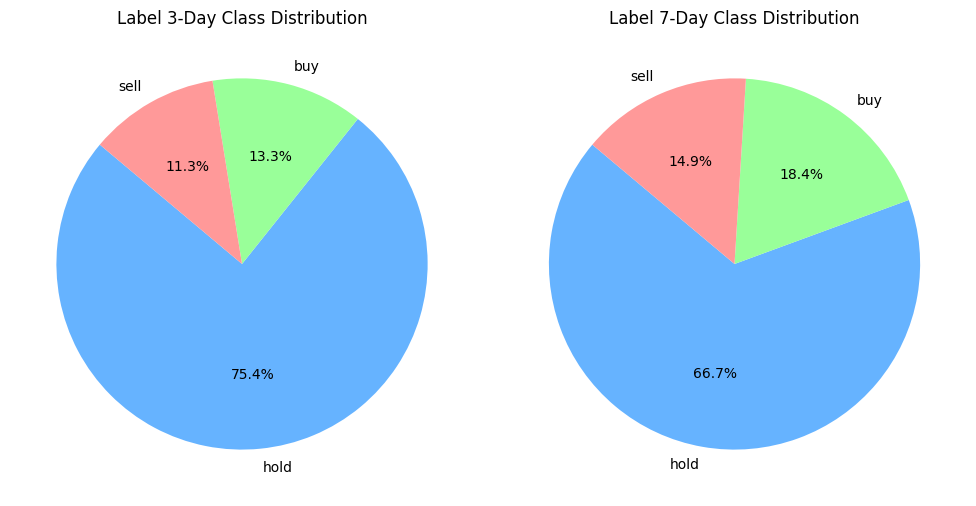

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

training_data = pd.read_csv("training_data.csv")

# Compute class distributions (percent)
label_3_counts = training_data['label_3'].value_counts(normalize=True) * 100
label_7_counts = training_data['label_7'].value_counts(normalize=True) * 100

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart for label_3
axs[0].pie(label_3_counts, labels=label_3_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#99ff99', '#ff9999'])
axs[0].set_title('Label 3-Day Class Distribution')

# Pie chart for label_7
axs[1].pie(label_7_counts, labels=label_7_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#99ff99', '#ff9999'])
axs[1].set_title('Label 7-Day Class Distribution')

plt.tight_layout()
plt.show()


# label_3 vs label_7 Distribution
- label_7 has more actionable movement
- label_7 label has less class imbalance
- first, we shall try to reuse the old technique, bit maybe tuning Optuna to be less extreme toward "hold" bias

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Encode label_7
le = LabelEncoder()
training_data['label_7_encoded'] = le.fit_transform(training_data['label_7'])

# Define features
drop_cols = ['label_3', 'label_7', 'label_7_encoded', 'date', 'stock', 'title']
feature_cols = [col for col in training_data.columns if col not in drop_cols]
X = training_data[feature_cols]
y = training_data['label_7_encoded']

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.15, random_state=42
)

# inverse class weight
class_counts = np.bincount(y_train)
total = len(y_train)
weights = total / (len(class_counts) * class_counts)
sample_weights = weights[y_train]


Classification Report:
              precision    recall  f1-score   support

         buy       0.36      0.57      0.44      3128
        hold       0.80      0.62      0.70     11332
        sell       0.34      0.44      0.38      2526

    accuracy                           0.58     16986
   macro avg       0.50      0.54      0.51     16986
weighted avg       0.65      0.58      0.60     16986



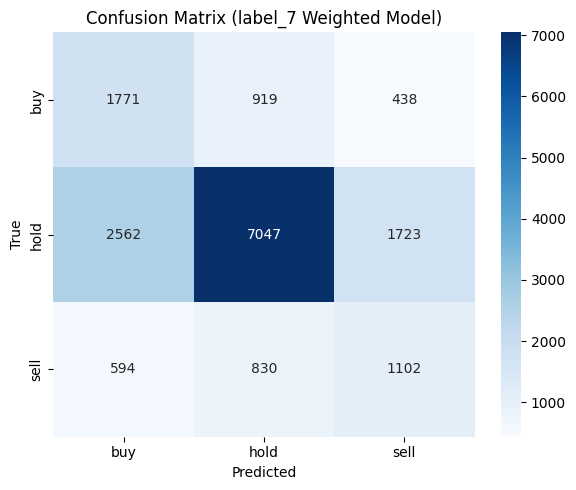

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train weighted XGBoost model
weighted_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

# Fit with sample weights
weighted_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict and evaluate
y_pred = weighted_model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (label_7 Weighted Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# label_7 Weighted Model Summary
- Overall accuracy dropped but class balance iproved

In [14]:
l7_study = optuna.create_study(direction='maximize')
l7_study.optimize(objective, n_trials=100)  # Can increase this to 200+ for better results

print("Best Params:", l7_study.best_params)
print("Best Macro F1:", l7_study.best_value)


[I 2025-05-20 00:18:11,308] A new study created in memory with name: no-name-00a4b44f-5604-4a80-b500-8e721019d47a
[I 2025-05-20 00:20:09,349] Trial 0 finished with value: 0.7584939978305106 and parameters: {'max_depth': 10, 'lr': 0.022411358970234805, 'n_estimators': 500, 'subsample': 0.8211417447590229}. Best is trial 0 with value: 0.7584939978305106.
[I 2025-05-20 00:20:17,619] Trial 1 finished with value: 0.5755645000358777 and parameters: {'max_depth': 6, 'lr': 0.15854532280516861, 'n_estimators': 100, 'subsample': 0.9362567012035877}. Best is trial 0 with value: 0.7584939978305106.
[I 2025-05-20 00:20:33,362] Trial 2 finished with value: 0.4880093050871115 and parameters: {'max_depth': 5, 'lr': 0.024241847545053992, 'n_estimators': 250, 'subsample': 0.7796537546337818}. Best is trial 0 with value: 0.7584939978305106.
[I 2025-05-20 00:20:48,089] Trial 3 finished with value: 0.5327893321034044 and parameters: {'max_depth': 3, 'lr': 0.22239551733945898, 'n_estimators': 400, 'subsampl

Best Params: {'max_depth': 10, 'lr': 0.2421680660372153, 'n_estimators': 550, 'subsample': 0.9629710985525788}
Best Macro F1: 0.8209276934615204


=== LABEL-7 Test Classification Report ===
               precision    recall  f1-score   support

         buy       0.88      0.71      0.78      4656
        hold       0.87      0.97      0.92     16013
        sell       0.91      0.69      0.79      3598

    accuracy                           0.88     24267
   macro avg       0.89      0.79      0.83     24267
weighted avg       0.88      0.88      0.87     24267



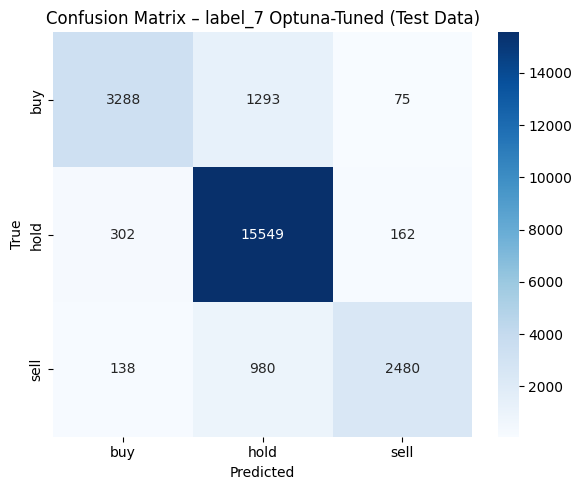

In [26]:
# -------------------- Imports --------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# -------------------- 1. Load data --------------------
train_df = pd.read_csv("training_data.csv")
test_df  = pd.read_csv("testing_data.csv")

# -------------------- 2. Encode label_7 --------------------
le = LabelEncoder()
train_df["label_7_encoded"] = le.fit_transform(train_df["label_7"])
test_df["label_7_encoded"]  = le.transform(test_df["label_7"])

# -------------------- 3. Features --------------------
drop_cols = ["label_3", "label_7", "label_7_encoded", "date", "stock", "title"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df["label_7_encoded"]
X_test  = test_df[feature_cols]
y_test  = test_df["label_7_encoded"]

# -------------------- 4. Inverse class-weights --------------------
class_counts = np.bincount(y_train)
weights = len(y_train) / (len(class_counts) * class_counts)
sample_weights = weights[y_train]

# -------------------- 5. Optuna-best parameters --------------------
best_params_label7 = {
    "max_depth": 10,
    "learning_rate": 0.2421680660372153,
    "n_estimators": 550,
    "subsample": 0.9629710985525788,
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "random_state": 42,
}

# -------------------- 6. Train & predict --------------------
l7_model = XGBClassifier(**best_params_label7)
l7_model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = l7_model.predict(X_test)

# -------------------- 7. Report & confusion matrix --------------------
report = classification_report(y_test, y_pred, target_names=le.classes_)
cm     = confusion_matrix(y_test, y_pred)

print("=== LABEL-7 Test Classification Report ===\n", report)
with open("label7_optuna_report.txt", "w") as f:
    f.write("LABEL-7 – Test Classification Report\n")
    f.write(report)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – label_7 Optuna-Tuned (Test Data)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("label7_optuna_confusion_matrix.png")
plt.show()


=== LABEL 3 on Validation Set ===
              precision    recall  f1-score   support

         buy       0.92      0.71      0.80      3181
        hold       0.91      0.99      0.95     18306
        sell       0.94      0.70      0.80      2784

    accuracy                           0.92     24271
   macro avg       0.92      0.80      0.85     24271
weighted avg       0.92      0.92      0.91     24271



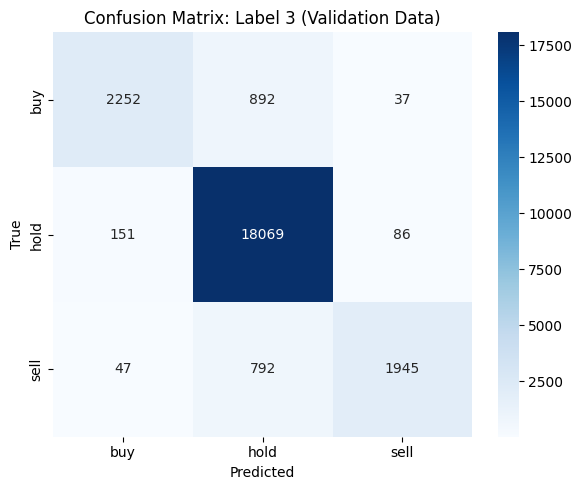

=== LABEL 7 on Validation Set ===
              precision    recall  f1-score   support

         buy       0.88      0.70      0.78      4439
        hold       0.87      0.97      0.92     16241
        sell       0.93      0.69      0.79      3591

    accuracy                           0.88     24271
   macro avg       0.89      0.79      0.83     24271
weighted avg       0.88      0.88      0.88     24271



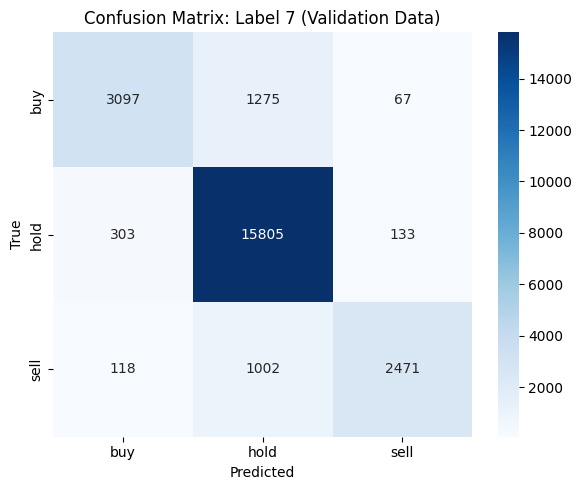

In [29]:
# validation dataset
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load validation data
val_df = pd.read_csv("validation_data.csv")

# Encode labels
val_df['label_3_encoded'] = le.fit_transform(val_df['label_3'])
val_df['label_7_encoded'] = le.fit_transform(val_df['label_7'])

# Shared drop columns
drop_cols = ['label_3', 'label_3_encoded', 'label_7', 'label_7_encoded', 'date', 'stock', 'title']
feature_cols = [col for col in val_df.columns if col not in drop_cols]

# Extract features
X_val = val_df[feature_cols]

# ========================
# LABEL 3 EVALUATION
# ========================
y_true_l3 = val_df['label_3_encoded']
y_pred_l3 = l3_model.predict(X_val)

print("=== LABEL 3 on Validation Set ===")
print(classification_report(y_true_l3, y_pred_l3, target_names=le.classes_))

cm_l3 = confusion_matrix(y_true_l3, y_pred_l3)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_l3, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: Label 3 (Validation Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ========================
# LABEL 7 EVALUATION
# ========================
y_true_l7 = val_df['label_7_encoded']
y_pred_l7 = l7_model.predict(X_val)

print("=== LABEL 7 on Validation Set ===")
print(classification_report(y_true_l7, y_pred_l7, target_names=le.classes_))

cm_l7 = confusion_matrix(y_true_l7, y_pred_l7)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_l7, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: Label 7 (Validation Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Save classification reports to a text file
with open("validation_results.txt", "w") as f:
    f.write("=== LABEL 3 on Validation Set ===\n")
    f.write(classification_report(y_true_l3, y_pred_l3, target_names=le.classes_))
    f.write("\n=== LABEL 7 on Validation Set ===\n")
    f.write(classification_report(y_true_l7, y_pred_l7, target_names=le.classes_))

# Save confusion matrix for Label 3
plt.figure(figsize=(6, 5))
sns.heatmap(cm_l3, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: Label 3 (Validation Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_label3_validation.png")
plt.close()

# Save confusion matrix for Label 7
plt.figure(figsize=(6, 5))
sns.heatmap(cm_l7, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: Label 7 (Validation Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_label7_validation.png")
plt.close()



In [42]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.8 MB/s eta 0:00:00


In [45]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Target directory on Google Drive
drive_dir = "/content/drive/MyDrive/xgboost_reports"
os.makedirs(drive_dir, exist_ok=True)

# List of files to save
files_to_save = [
    "label3_optuna_report.txt",
    "label3_optuna_confusion_matrix.png",
    "label7_optuna_report.txt",
    "label7_optuna_confusion_matrix.png",
    "confusion_label3_validation.png",
    "confusion_label7_validation.png",
    "optuna_results_summary.pdf",
    "validation_results.txt"
]

# Copy files to Google Drive
for file in files_to_save:
    shutil.copy(file, os.path.join(drive_dir, file))

print(f"✅ All files saved to: {drive_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All files saved to: /content/drive/MyDrive/xgboost_reports
